#Recommender System with MovieLens

In this notebook a system of recommendations is implemented considering the MovieLens dataset, available at the following link: https://www.kaggle.com/rounakbanik/the-movies-dataset.

This recommendation system is a "User-based Collaborative Filtering" that makes use of the Pearson correlation to calculate the similarity between users.

An example of the algorithm scheme is shown below.



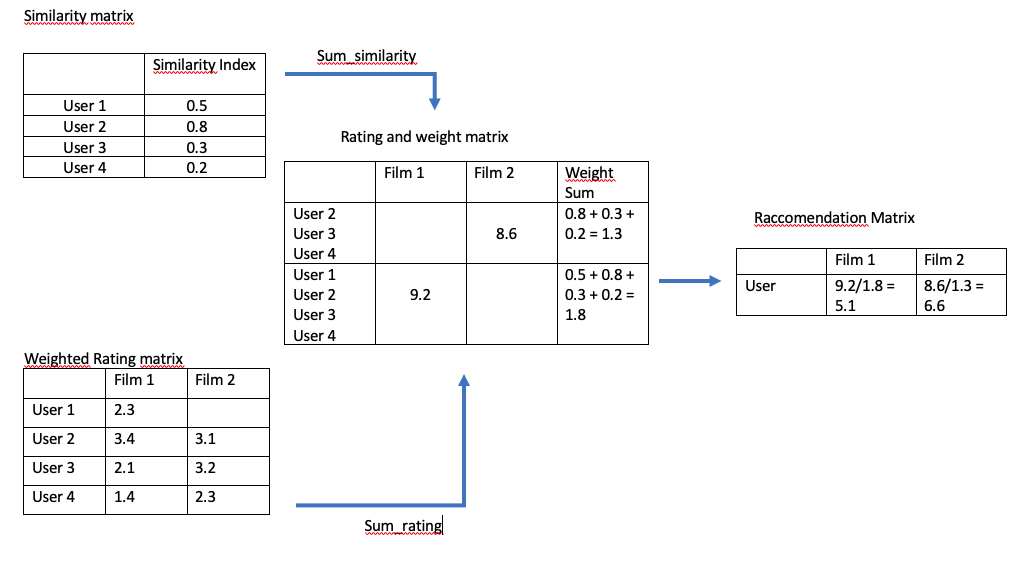

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt

#I load the movie and rating datasets from the downloaded dataset
movies = pd.read_csv('./sample_data/movie.csv')
ratings = pd.read_csv('./sample_data/rating.csv')

movies.head()



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
#The year is removed from the title
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
movies['title'] = movies['title'].apply(lambda x: x.strip())

#Genres columns of movies and rating timestamps are deleted
movies = movies.drop('genres', 1)
ratings = ratings.drop('timestamp', 1)

movies.head()

,movieId,title
0,1,Toy Story
1,2,Jumanji
2,3,Grumpier Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [ ]:
#I create an input user with some movies and their rating
user = [
{'title': 'Fight Club', 'rating': 5},
{'title': 'Toy Story', 'rating': 3.5},
{'title': 'Dark Knight, The', 'rating': 2},
{'title': 'Pulp Fiction', 'rating': 4},
{'title': 'Shawshank Redemption, The', 'rating': 5},
{'title': 'Godfather, The', 'rating': 5},

]
inputMovies = pd.DataFrame(user)
inputMovies


,title,rating
0,Fight Club,5.0
1,Toy Story,3.5
2,"Dark Knight, The",2.0
3,Pulp Fiction,4.0
4,"Shawshank Redemption, The",5.0
5,"Godfather, The",5.0


In [ ]:
#I extract from the dataset the films I have in the input
extraction = movies[movies['title'].isin(inputMovies['title'].tolist())]

extraction.head()

,movieId,title
0,1,Toy Story
293,296,Pulp Fiction
315,318,"Shawshank Redemption, The"
843,858,"Godfather, The"
2873,2959,Fight Club


In [ ]:
#I combine the two small datasets created (input and extraction)
union = pd.merge(extraction, inputMovies)

union


,movieId,title,rating
0,1,Toy Story,3.5
1,296,Pulp Fiction,4.0
2,318,"Shawshank Redemption, The",5.0
3,858,"Godfather, The",5.0
4,2959,Fight Club,5.0
5,58559,"Dark Knight, The",2.0


In [ ]:
#I extract the users who watched the input movies, group by userId and order
userSubset = ratings[ratings['movieId'].isin(union['movieId'].tolist())]

userSubsetGroup = userSubset.groupby(['userId'])

userSubsetGroup = sorted(userSubsetGroup, key=lambda x: len(x[1]), reverse=True)

userSubsetGroupExample = userSubsetGroup[0:2]
userSubsetGroupExample


[(11,       userId  movieId  rating
  960       11      1.0     4.5
  983       11    296.0     3.5
  985       11    318.0     5.0
  1028      11    858.0     2.5
  1131      11   2959.0     4.5
  1418      11  58559.0     5.0), (96,        userId  movieId  rating
  10425      96      1.0     3.5
  10434      96    296.0     4.5
  10435      96    318.0     4.5
  10454      96    858.0     3.0
  10531      96   2959.0     4.5
  10740      96  58559.0     4.5)]

From the output we can see the first two Users, that is those with ID 11 and 96, who have seen and evaluated the films taken into consideration.

In [ ]:
#The first 100 users are considered
userSubsetGroup = userSubsetGroup[0:100]

#It uses a dictionary to store the Pearson correlation, keyed in the user ID value is the coefficiente
pearsonCorrelationDict = {}

for name, group in userSubsetGroup:
    
    #Sort by movieId
    group = group.sort_values(by='movieId')
    union = union.sort_values(by='movieId')
    
    nRatings = len(group)
    
    #The scores of the film evaluations that both datasets (Union and Group) have in common are extracted
    # and are stored in a buffer variable
    temp_df = union[union['movieId'].isin(group['movieId'].tolist())]
    tempRatingList = temp_df['rating'].tolist()
    
    tempGroupList = group['rating'].tolist()
    
    #The Pearson correlation between two users is calculated
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)

    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0



In [ ]:
#Convert the previously created dictionary into a dataframe
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()



,similarityIndex,userId
0,-0.395308,11
1,-0.198423,96
2,0.130610,115
3,0.641858,208
4,-0.248862,215


In [ ]:
#The first 20 users who are most similar to the input are extracted:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:20]
topUsers



,similarityIndex,userId
8,0.945676,370
39,0.945676,1528
67,0.866847,2295
34,0.799040,1341
23,0.790112,969
40,0.771789,1554
76,0.741374,2544
11,0.724270,482
79,0.717252,2663
65,0.699703,2270


These are the first 20 closest users (according to Pearson's correlation) to the user given in input.

We must now recommend the movies to the user.

To do this, we take the weighted average of the film ratings using the previously calculated Pearson correlation as weight.

We must first get the movies watched by users in our pearsonDF from the ratings dataframe and then store their correlation in a new column called similarityIndex.

We do this by combining the two topUsers and ratings tables.

In [ ]:
#Union of ratings and topUsers
topUsersRating=topUsers.merge(ratings, left_on='userId', right_on='userId', how='inner')

#The evaluation of the film is multiplied by its weight (the similarity index),
#then the new evaluations are added up and divided by the sum of the weights.
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']

#All users similar to the candidate films are shown for the input user
topUsersRating.head()

,similarityIndex,userId,movieId,rating,weightedRating
0,0.945676,370,1.0,4.5,4.255540
1,0.945676,370,2.0,4.0,3.782702
2,0.945676,370,6.0,5.0,4.728378
3,0.945676,370,25.0,4.5,4.255540
4,0.945676,370,32.0,5.0,4.728378


In [ ]:
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sumSimilarityIndex','sumWeightedRating']
tempTopUsersRating.head()


,sumSimilarityIndex,sumWeightedRating
movieId,,
1.0,14.345587,54.868982
2.0,5.861660,18.091695
3.0,1.342684,2.685369
4.0,0.684257,1.368515
5.0,1.342684,3.356711


In [ ]:
#I create an empty dataframe
recommendation_df = pd.DataFrame()

#Weighted average
recommendation_df['weighted_average_recommendation_score'] = tempTopUsersRating['sumWeightedRating']/tempTopUsersRating['sumSimilarityIndex']
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()



,weighted_average_recommendation_score,movieId
movieId,,
1.0,3.824799,1.0
2.0,3.086446,2.0
3.0,2.000000,3.0
4.0,2.000000,4.0
5.0,2.500000,5.0


In [ ]:
#Let's order it and see the top 20 movies recommended by the algorithm.
recommendation_df = recommendation_df.sort_values(by='weighted_average_recommendation_score', ascending=False)

movies.loc[movies['movieId'].isin(recommendation_df.head(20)['movieId'].tolist())]

,movieId,title
179,181,Mighty Morphin Power Rangers: The Movie
1127,1150,"Return of Martin Guerre, The (Retour de Martin..."
1215,1243,Rosencrantz and Guildenstern Are Dead
1980,2064,Roger & Me
2539,2624,After Life (Wandafuru raifu)
2637,2723,Mystery Men
3656,3747,Jesus' Son
4792,4888,Tape
4979,5075,Waydowntown
6005,6104,Monty Python Live at the Hollywood Bowl


These are the top 20 films recommended by the User-based algorithm.